In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Loading VGG16

In [2]:
model = tf.keras.applications.vgg16.VGG16(weights="imagenet")
model.summary()

553467096/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

### Filter visualization

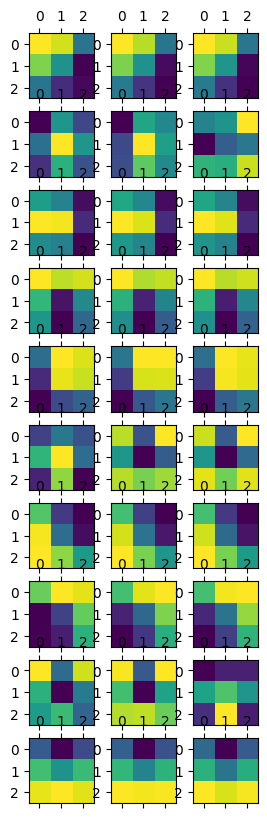

In [3]:
import matplotlib.pyplot as plt

weights = model.get_layer('block1_conv1').weights[0]

fig = plt.figure(figsize=(3,10))
for i in range(10):
    for j in range(3):
        pl = fig.add_subplot(10,3,i*3+j+1)
        pl.matshow(weights[:, :, j, i])

### Feature map visualization

In [7]:
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/drive')

img = cv2.imread('drive/MyDrive/Test/LIG/dogs.jpg',cv2.IMREAD_COLOR)
img = cv2.resize(img, (224,224))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
img.shape

(224, 224, 3)

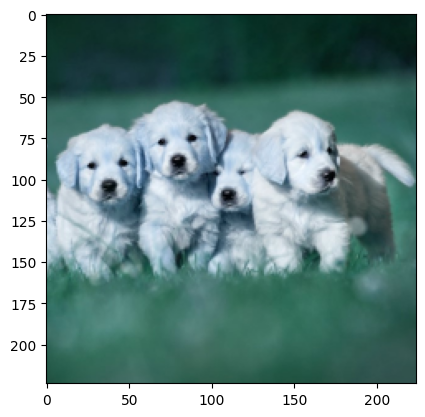

In [8]:
plt.imshow(img)

In [11]:
activ_model = tf.keras.models.Model (
    inputs=model.input,
    outputs=model.get_layer('block1_conv1').output
)
channel_activ = activ_model.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 1s 715ms/step


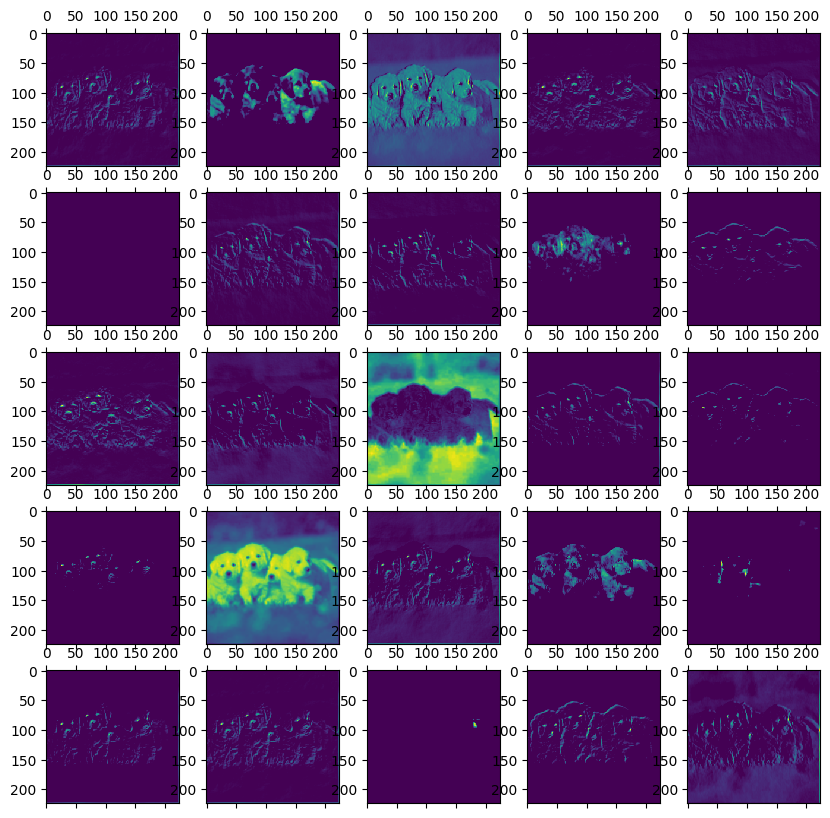

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    pl = fig.add_subplot(5,5,i+1)
    pl.matshow(channel_activ[0, :, :, i])

In [13]:
activ_model = tf.keras.models.Model (
    inputs=model.input,
    outputs=model.get_layer('block4_conv3').output
)
channel_activ = activ_model.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 2s 2s/step


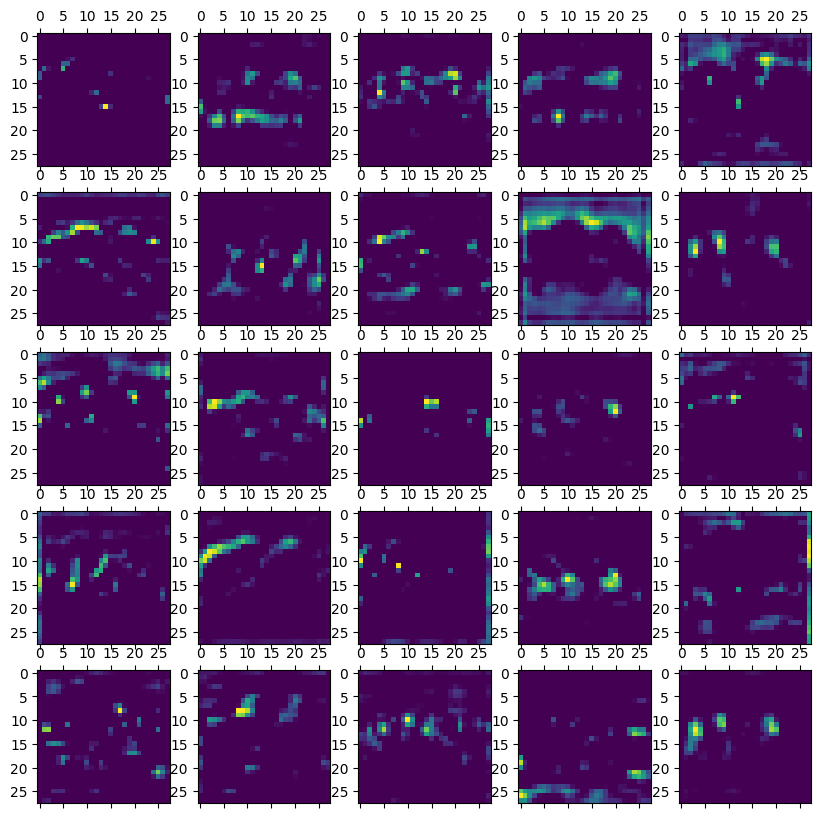

In [14]:
fig = plt.figure(figsize=(10,10))
for i in range(25):
    pl = fig.add_subplot(5,5,i+1)
    pl.matshow(channel_activ[0, :, :, i])

### Activation maximization

In [15]:
def compute_loss(input_image, filter_no):
    channel_activation = activ_model(tf.expand_dims(input_image, axis=0))
    return -tf.reduce_mean(channel_activation[:, 1:-1, 1:-1, filter_no]) + \
                regularization(input_image)

In [16]:
def regularization(x):
    tv = tf.image.total_variation(x) / np.prod(x.shape)
    return 10. * (tv + tf.math.l2_normalize(x))

In [17]:
def initialize_random_image():
    return tf.Variable(tf.random.uniform((224, 224, 3), 0., 1.) * 0.25)

In [18]:
from tensorflow.keras.preprocessing.image import random_rotation

def input_modifier(x):
    x.assign(tf.roll(x, shift=[np.random.randint(-1, 1), np.random.randint(-1, 1)], axis=(0, 1)))
    
    return tf.Variable(random_rotation(x.numpy(), 1., row_axis=0, col_axis=1, channel_axis=2))

In [19]:
def deprocess_image(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    return img

In [20]:
def visualize_filter(filter_index, lr=0.1):
    img = initialize_random_image()
    
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    
    for iteration in range(200):
        img = input_modifier(img)
        
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(img)
            loss = compute_loss(img, filter_index)
            
        # Compute gradients.
        grads = tape.gradient(loss, img, 
                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
        opt.apply_gradients(zip([grads], [img]))

    # Decode the resulting input image
    img = deprocess_image(img.numpy())
    return loss, img

### block5_conv3

In [ ]:
activ_model = tf.keras.models.Model (
    inputs=model.input,
    outputs=model.get_layer('block5_conv3').output
)
activ_model.layers[-1].activation = tf.keras.activations.linear

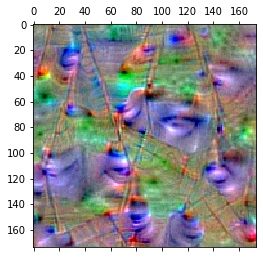

In [ ]:
loss, img = visualize_filter(21)
plt.matshow(img)

### Logit visualization

In [27]:
def compute_loss(input_image, filter_no):
    channel_activation = activ_model(tf.expand_dims(input_image, axis=0))
    return -tf.reduce_mean(channel_activation[:, filter_no]) + regularization(input_image)

In [28]:
activ_model = tf.keras.models.Model (
    inputs=model.input,
    outputs=model.output
)
activ_model.layers[-1].activation = tf.keras.activations.linear

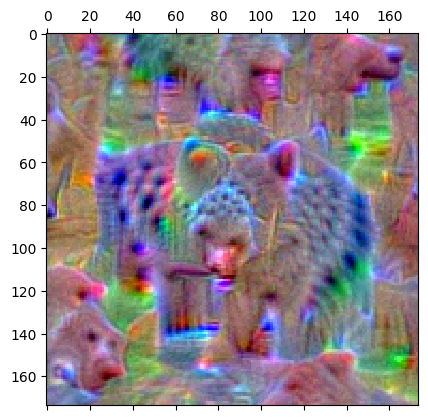

In [29]:
# bear
loss, img = visualize_filter(294)
plt.matshow(img)

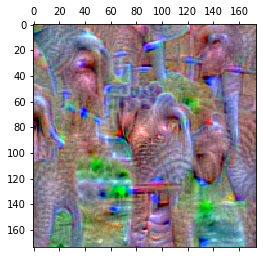

In [ ]:
# elephant
loss, img = visualize_filter(385)
plt.matshow(img)

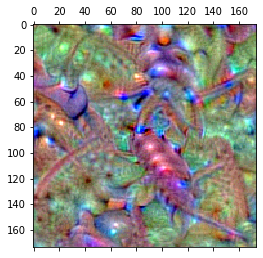

In [ ]:
# lobster
loss, img = visualize_filter(122)
plt.matshow(img)

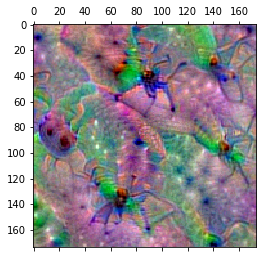

In [ ]:
# ant
loss, img = visualize_filter(310)
plt.matshow(img)

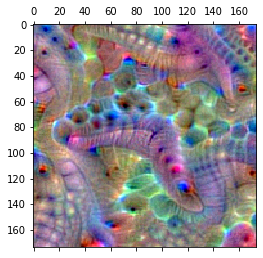

In [ ]:
# star fish
loss, img = visualize_filter(327)
plt.matshow(img)